

## ML


### Data loading

In [4]:
#!pip install -q sentence-transformers


In [5]:
#!pip install --upgrade --force-reinstall numpy pandas scikit-learn gensim


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer


In [7]:

file_path = "/content/Artificial_Data.xlsx"
df = pd.read_excel(file_path)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist()[:10], "...")

Shape: (100, 154)
Columns: ['RATING_TYPE', 'Rating', 'FundaIndxint', 'FundaIndxsga', 'monthvwretd', 'monthvwretx', 'monthewretd', 'monthewretx', 'monthsprtrn', 'monthspindx'] ...


In [8]:
print("Data Types:")
print(df.dtypes.value_counts())

Data Types:
float64    151
object       3
Name: count, dtype: int64


### EDA & Preprocessing

In [9]:
df.describe(include='all').T.head(10)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
RATING_TYPE,100,3,S&P,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rating,100,8,BBB,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FundaIndxint,100.0,NaN,NaN,NaN,-0.067201,1.01737,-2.318068,-0.733156,-0.150513,0.537932,3.061095
FundaIndxsga,100.0,NaN,NaN,NaN,0.075317,1.029466,-2.339597,-0.587366,0.100186,0.750813,3.253985
monthvwretd,100.0,NaN,NaN,NaN,0.010728,1.09158,-3.478169,-0.681876,0.020146,0.613014,2.539258
monthvwretx,100.0,NaN,NaN,NaN,0.127477,1.093258,-2.27795,-0.528532,0.141856,0.704034,2.6167
monthewretd,100.0,NaN,NaN,NaN,0.093248,1.11135,-2.572931,-0.636587,0.208633,0.806156,3.174442
monthewretx,100.0,NaN,NaN,NaN,0.03218,1.088224,-3.568205,-0.62485,0.037285,0.824912,2.760762
monthsprtrn,100.0,NaN,NaN,NaN,-0.026623,1.0251,-2.71249,-0.51138,0.052313,0.733167,1.601238
monthspindx,100.0,NaN,NaN,NaN,0.107747,0.881458,-1.846772,-0.542076,0.076285,0.649335,2.564058


In [10]:
missing_counts = df.isnull().sum().sort_values(ascending=False)
missing_counts


,0
RATING_TYPE,0
trfm,0
ustrecpiret,0
ajexm,0
ajpm,0
...,...
usind2CRSPMEG1,0
usind2CRSPLCV1,0
usind2CRSPLCG1,0
usind2CRSPMIV1,0


In [11]:
print(" Summary statistics:")
print(df.describe(include='all').T)

 Summary statistics:
               count unique  \
RATING_TYPE      100      3   
Rating           100      8   
FundaIndxint   100.0    NaN   
FundaIndxsga   100.0    NaN   
monthvwretd    100.0    NaN   
...              ...    ...   
rd_sale        100.0    NaN   
adv_sale       100.0    NaN   
staff_sale     100.0    NaN   
accrual        100.0    NaN   
string_values    100      5   

                                                             top freq  \
RATING_TYPE                                                  S&P   36   
Rating                                                       BBB   18   
FundaIndxint                                                 NaN  NaN   
FundaIndxsga                                                 NaN  NaN   
monthvwretd                                                  NaN  NaN   
...                                                          ...  ...   
rd_sale                                                      NaN  NaN   
adv_sale              

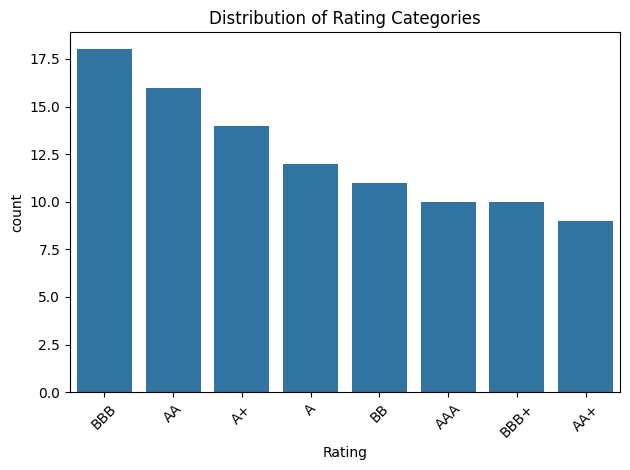

In [12]:
sns.countplot(x='Rating', data=df, order=df['Rating'].value_counts().index)
plt.title('Distribution of Rating Categories')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

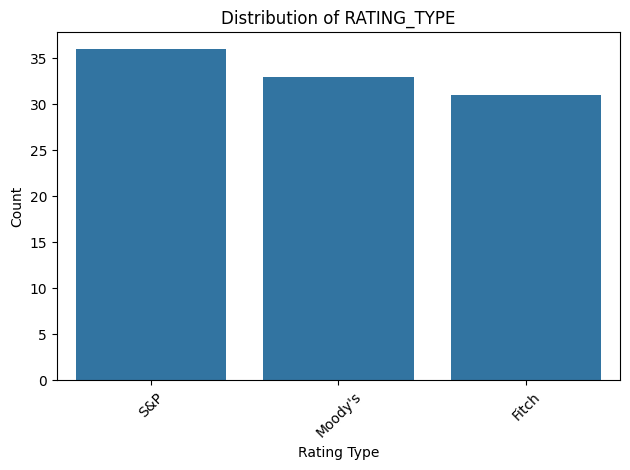

In [13]:
sns.countplot(data=df, x='RATING_TYPE', order=df['RATING_TYPE'].value_counts().index)
plt.title("Distribution of RATING_TYPE")
plt.xlabel("Rating Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

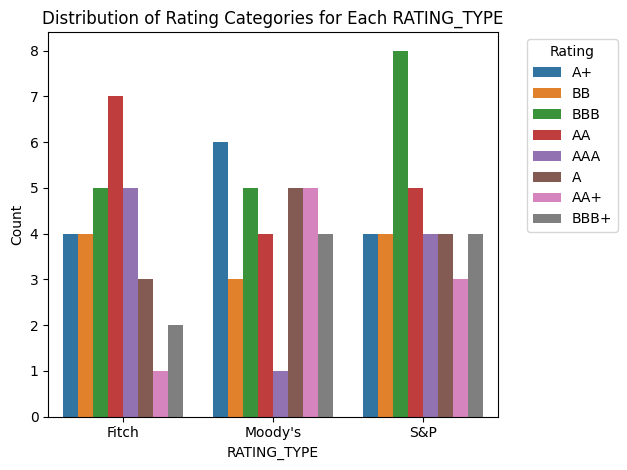

In [14]:

sns.countplot(data=df, x='RATING_TYPE', hue='Rating')
plt.title("Distribution of Rating Categories for Each RATING_TYPE")
plt.xlabel("RATING_TYPE")
plt.ylabel("Count")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-15-070135913a46>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


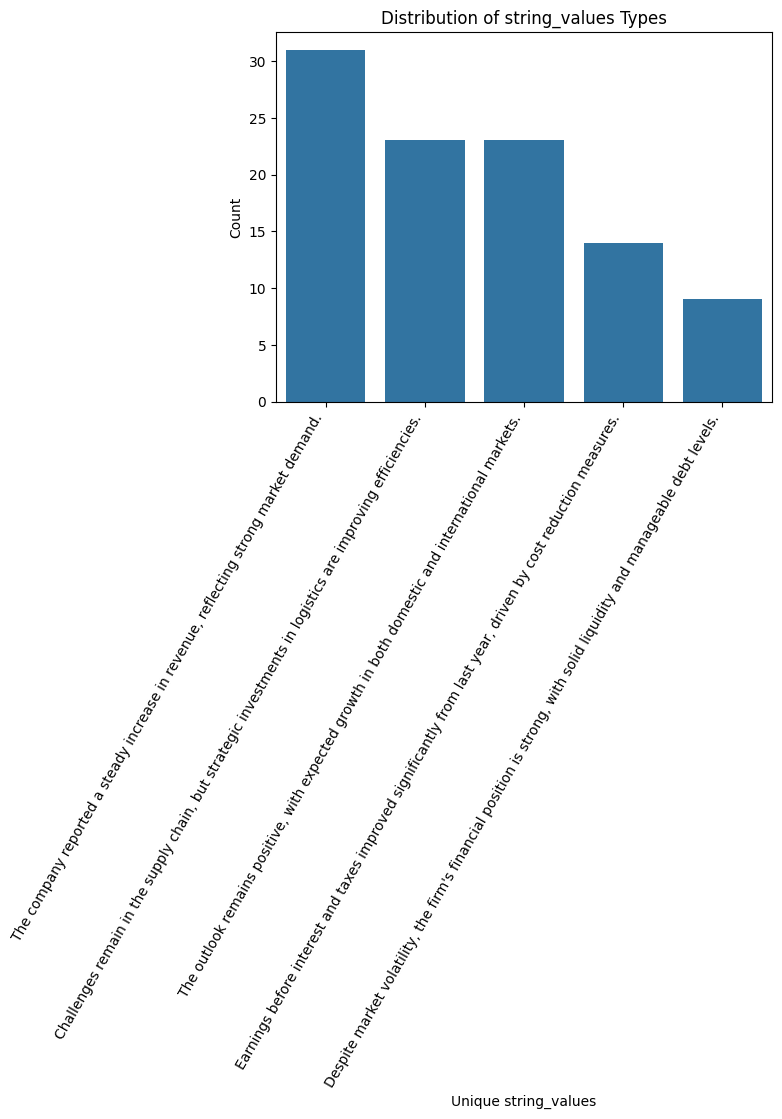

 Unique string_values types:
['The company reported a steady increase in revenue, reflecting strong market demand.', 'Challenges remain in the supply chain, but strategic investments in logistics are improving efficiencies.', 'The outlook remains positive, with expected growth in both domestic and international markets.', 'Earnings before interest and taxes improved significantly from last year, driven by cost reduction measures.', "Despite market volatility, the firm's financial position is strong, with solid liquidity and manageable debt levels."]


In [15]:
value_counts = df['string_values'].value_counts().reset_index()
value_counts.columns = ['string_value_type', 'count']
sns.barplot(data=value_counts, x='string_value_type', y='count')
plt.title("Distribution of string_values Types")
plt.xlabel("Unique string_values")
plt.ylabel("Count")
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()
print(" Unique string_values types:")
print(value_counts['string_value_type'].tolist())

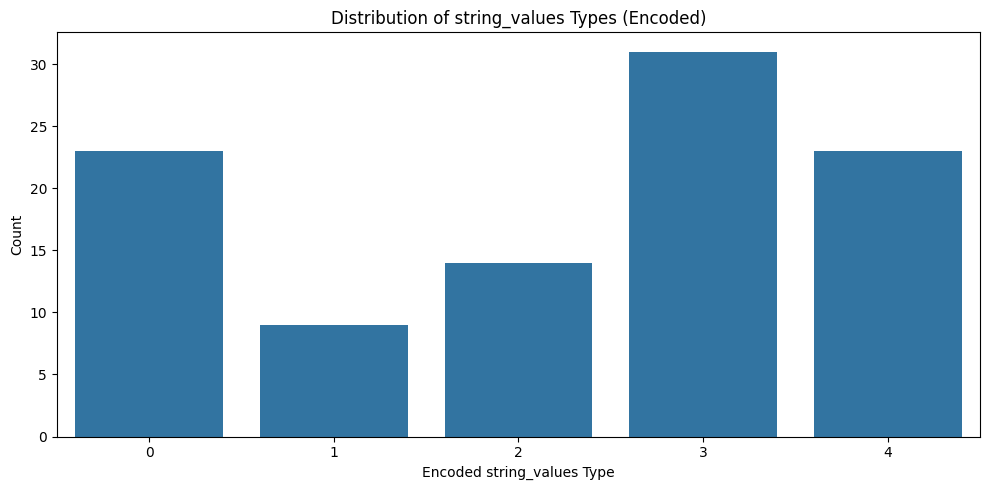

Mapping of Encoded string_values:
0: Challenges remain in the supply chain, but strategic investments in logistics are improving efficiencies.
1: Despite market volatility, the firm's financial position is strong, with solid liquidity and manageable debt levels.
2: Earnings before interest and taxes improved significantly from last year, driven by cost reduction measures.
3: The company reported a steady increase in revenue, reflecting strong market demand.
4: The outlook remains positive, with expected growth in both domestic and international markets.


In [16]:

string_encoder = LabelEncoder()
df['string_encoded'] = string_encoder.fit_transform(df['string_values'])
value_counts = df['string_values'].value_counts().reset_index()
value_counts.columns = ['string_value_type', 'count']
value_counts['string_encoded'] = value_counts['string_value_type'].map(
    {label: code for label, code in zip(string_encoder.classes_, string_encoder.transform(string_encoder.classes_))}
)

plt.figure(figsize=(10, 5))
sns.barplot(data=value_counts, x='string_encoded', y='count')
plt.title("Distribution of string_values Types (Encoded)")
plt.xlabel("Encoded string_values Type")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("Mapping of Encoded string_values:")
for label, code in zip(string_encoder.classes_, string_encoder.transform(string_encoder.classes_)):
    print(f"{code}: {label}")

In [17]:
rating_string_relation = df.groupby(['RATING_TYPE', 'string_values']).size().reset_index(name='count')
pivot_table = rating_string_relation.pivot(index='RATING_TYPE', columns='string_values', values='count').fillna(0)
print(" Count of string_values per RATING_TYPE:")
print(pivot_table)

 Count of string_values per RATING_TYPE:
string_values  Challenges remain in the supply chain, but strategic investments in logistics are improving efficiencies.  \
RATING_TYPE                                                                                                                
Fitch                                                          7                                                           
Moody's                                                        7                                                           
S&P                                                            9                                                           

string_values  Despite market volatility, the firm's financial position is strong, with solid liquidity and manageable debt levels.  \
RATING_TYPE                                                                                                                           
Fitch                                                          5    

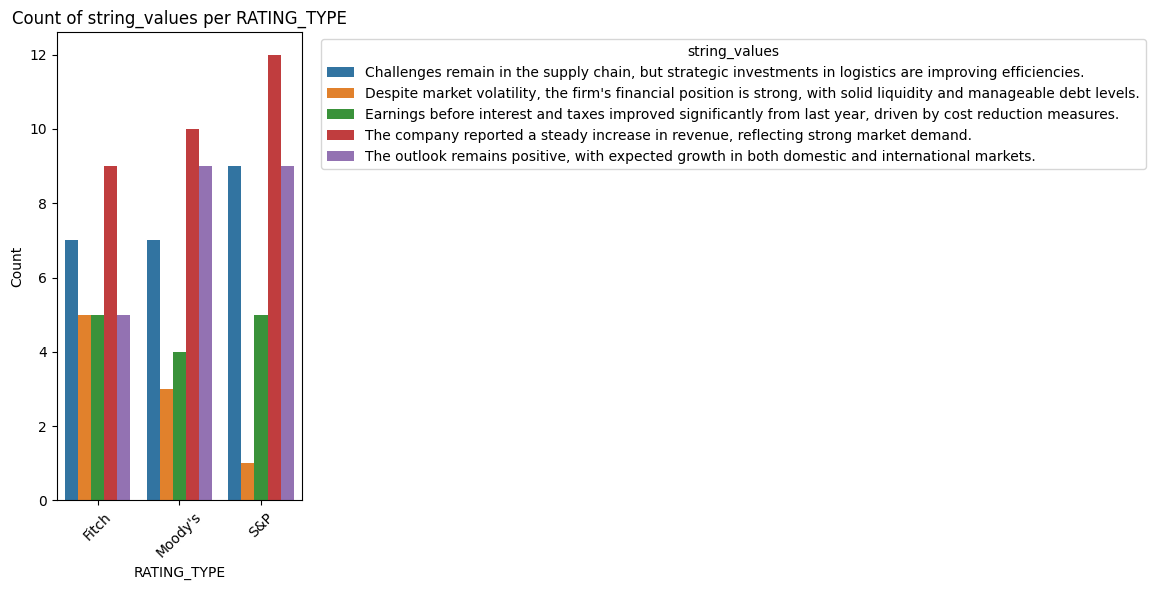

In [18]:
plt.figure(figsize=(12,6))
sns.barplot(data=rating_string_relation, x='RATING_TYPE', y='count', hue='string_values')
plt.title("Count of string_values per RATING_TYPE")
plt.ylabel("Count")
plt.xlabel("RATING_TYPE")
plt.xticks(rotation=45)
plt.legend(title="string_values", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-19-a8deff5779b8>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


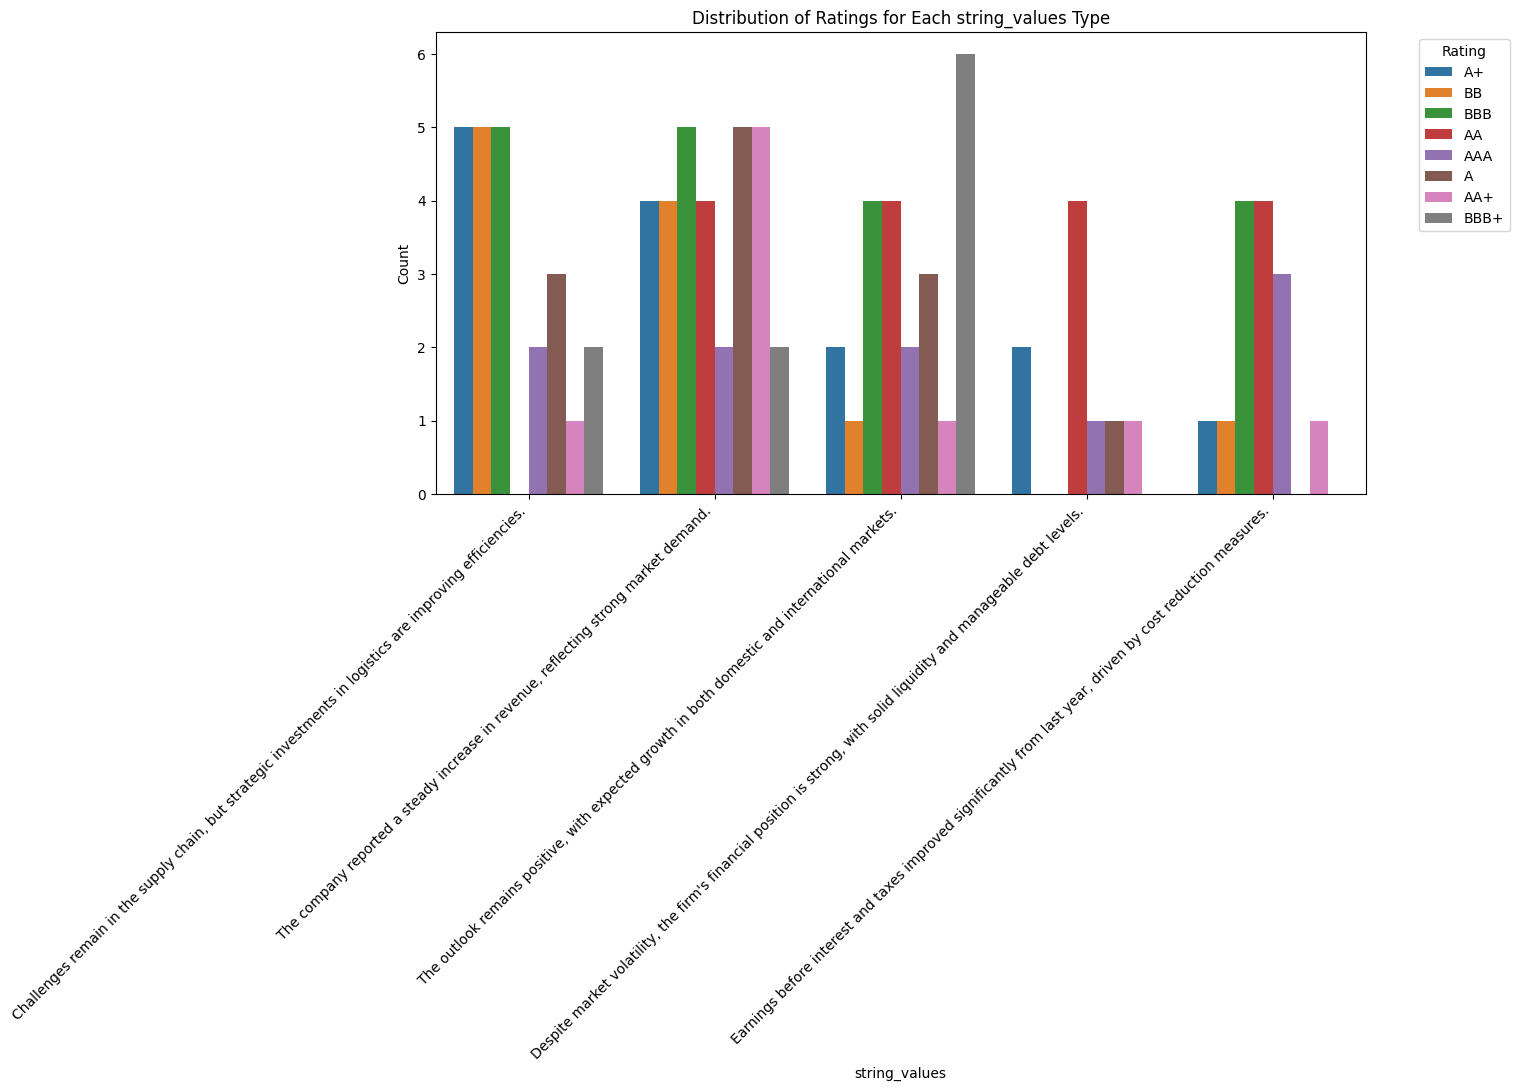

In [19]:

plt.figure(figsize=(12,6))
sns.countplot(data=df, x='string_values', hue='Rating')
plt.title("Distribution of Ratings for Each string_values Type")
plt.xlabel("string_values")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

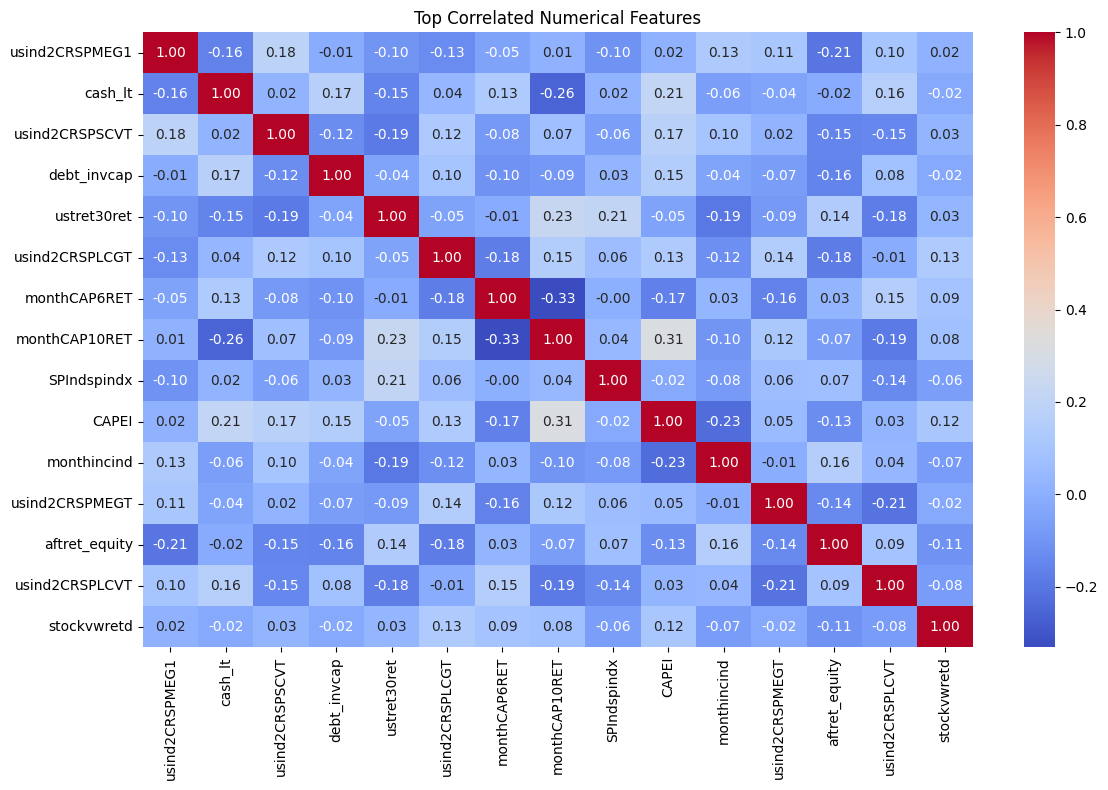

In [20]:
numeric_cols = df.select_dtypes(include='float64').columns
top_corr_cols = df[numeric_cols].corr().abs().sum().sort_values(ascending=False).head(15).index

plt.figure(figsize=(12,8))
sns.heatmap(df[top_corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top Correlated Numerical Features")
plt.tight_layout()
plt.show()

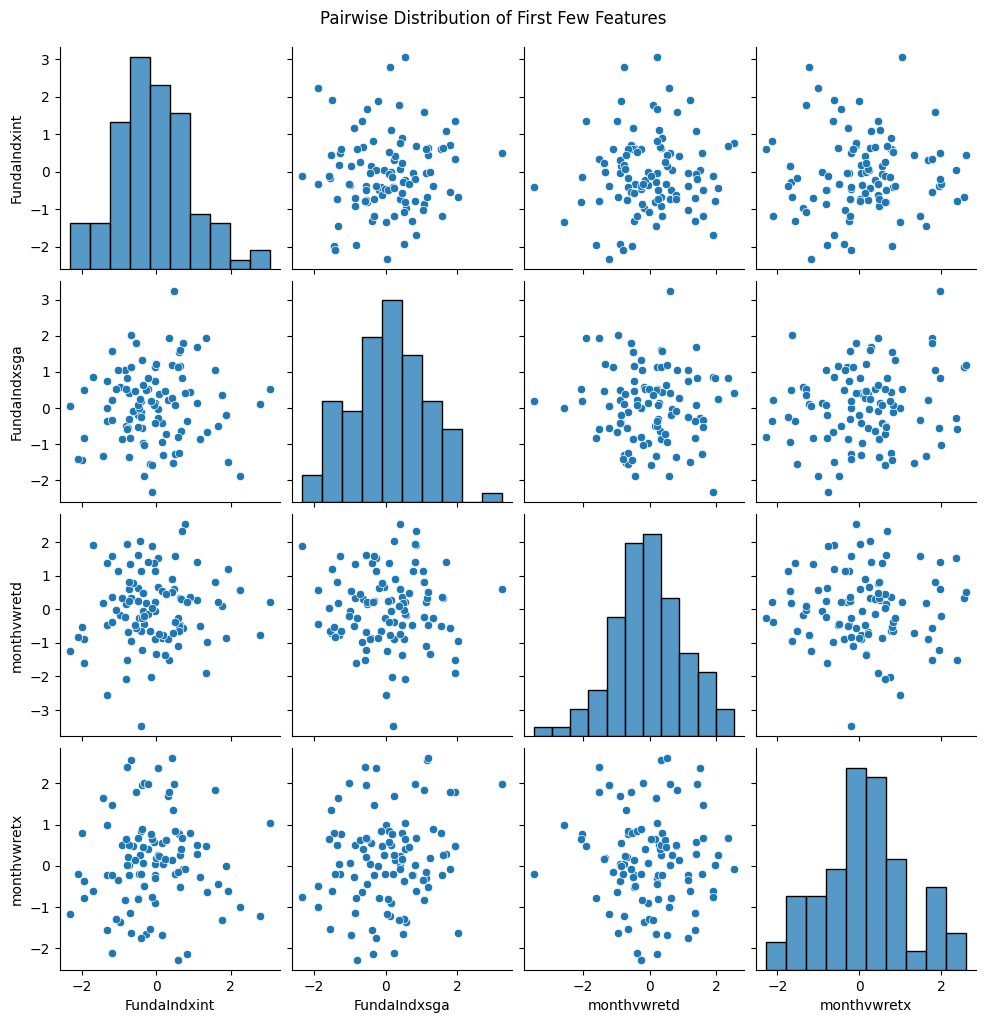

In [21]:
sns.pairplot(df[numeric_cols[:4]])
plt.suptitle("Pairwise Distribution of First Few Features", y=1.02)
plt.show()


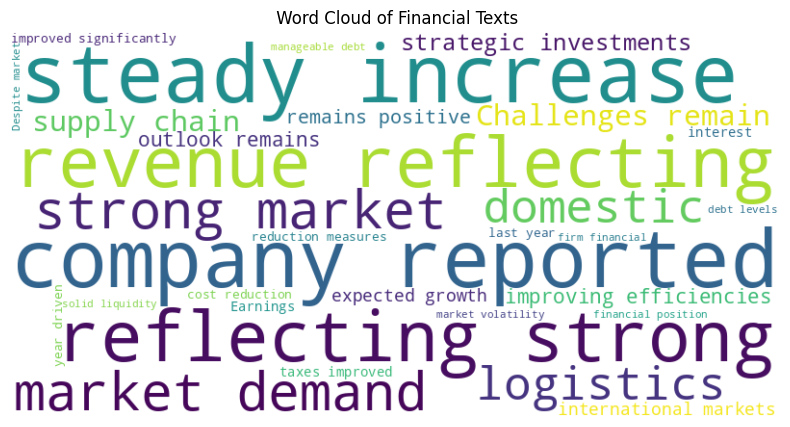

In [22]:
from wordcloud import WordCloud

text = ' '.join(df['string_values'].dropna().astype(str).tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(" Word Cloud of Financial Texts")
plt.show()

 IQR-Based Outlier Indices (sample):
FundaIndxint: 2 outliers
FundaIndxsga: 1 outliers
monthvwretd: 1 outliers
monthvwretx: 2 outliers
monthewretd: 1 outliers


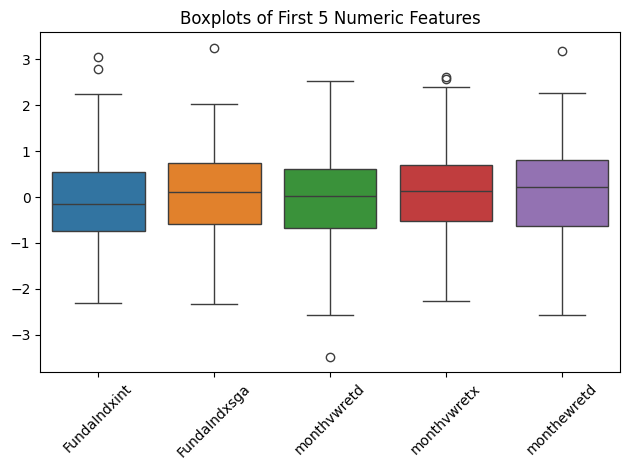

In [23]:

numeric_cols = df.select_dtypes(include='float64').columns

def detect_outliers_iqr(dataframe, columns):
    outlier_indices = {}
    for col in columns:
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = dataframe[(dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)]
        outlier_indices[col] = outliers.index.tolist()
    return outlier_indices

iqr_outliers = detect_outliers_iqr(df, numeric_cols)
print(" IQR-Based Outlier Indices (sample):")
for k, v in list(iqr_outliers.items())[:5]:
    print(f"{k}: {len(v)} outliers")


sns.boxplot(data=df[numeric_cols[:5]])
plt.title("Boxplots of First 5 Numeric Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
rating_encoder = LabelEncoder()
df['Rating_encoded'] = rating_encoder.fit_transform(df['Rating'])
rating_type_encoded = pd.get_dummies(df['RATING_TYPE'], prefix='RATING_TYPE')
df_cleaned = df.drop(columns=['Rating', 'RATING_TYPE'])
df_cleaned = pd.concat([df_cleaned, rating_type_encoded], axis=1)
df_cleaned[['Rating_encoded'] + list(rating_type_encoded.columns)].head()

,Rating_encoded,RATING_TYPE_Fitch,RATING_TYPE_Moody's,RATING_TYPE_S&P
0,1,True,False,False
1,5,False,True,False
2,5,True,False,False
3,6,True,False,False
4,2,False,True,False


In [25]:
rating_order = ['BB', 'BBB', 'BBB+', 'A', 'A+', 'AA', 'AA+', 'AAA']
rating_map = {rating: idx for idx, rating in enumerate(rating_order)}
df['Rating_encoded'] = df['Rating'].map(rating_map)
rating_type_encoded = pd.get_dummies(df['RATING_TYPE'], prefix='RATING_TYPE')
df_cleaned = df.drop(columns=['Rating', 'RATING_TYPE'])
df_cleaned = pd.concat([df_cleaned, rating_type_encoded], axis=1)
print(df_cleaned[['Rating_encoded'] + list(rating_type_encoded.columns)].head())

   Rating_encoded  RATING_TYPE_Fitch  RATING_TYPE_Moody's  RATING_TYPE_S&P
0               4               True                False            False
1               0              False                 True            False
2               0               True                False            False
3               1               True                False            False
4               5              False                 True            False


In [26]:
df_cleaned

,FundaIndxint,FundaIndxsga,monthvwretd,monthvwretx,monthewretd,monthewretx,monthsprtrn,monthspindx,monthCAP1RET,monthCAP2RET,...,rd_sale,adv_sale,staff_sale,accrual,string_values,string_encoded,Rating_encoded,RATING_TYPE_Fitch,RATING_TYPE_Moody's,RATING_TYPE_S&P
0,0.150659,-0.420047,-0.846934,0.560226,0.579303,-0.578314,-0.225006,-0.415867,-1.215753,-0.476301,...,1.878286,-1.338060,0.862565,0.822648,"Challenges remain in the supply chain, but str...",0,4,True,False,False
1,-0.015715,0.139204,-0.045250,-0.912128,0.497292,-0.910558,1.207592,-0.104050,0.154247,1.388313,...,1.426555,-1.121401,0.853764,0.978653,The company reported a steady increase in reve...,3,0,False,True,False
2,-1.330074,0.001814,-2.564342,0.997115,0.762847,-0.870865,0.230487,0.515273,-0.158655,1.659948,...,-2.171165,-0.533031,-0.615333,-0.302474,The company reported a steady increase in reve...,3,0,True,False,False
3,-0.025288,0.755935,1.142726,-0.235319,0.637967,-1.611961,0.432309,1.194182,-1.186642,1.275644,...,1.155982,-1.482237,0.000229,0.957513,The company reported a steady increase in reve...,3,1,True,False,False
4,1.343168,1.933543,-1.896747,0.467780,-0.442432,1.349705,0.541002,0.096545,-0.370209,0.230641,...,0.578200,-1.154929,0.531278,0.506149,The company reported a steady increase in reve...,3,5,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.815271,0.536027,-2.062526,0.643803,0.014212,1.143066,0.054319,0.640190,-1.363040,-1.334804,...,-0.193072,-0.536025,0.708392,-0.697977,"The outlook remains positive, with expected gr...",4,2,False,True,False
96,0.699092,0.840171,2.341975,0.683962,2.276652,-0.418705,1.138171,0.402768,-0.672489,1.109260,...,2.080314,1.201069,-1.304036,0.784470,"The outlook remains positive, with expected gr...",4,5,False,True,False
97,0.599897,1.133342,-1.101855,-0.144524,-1.629303,1.454928,-0.331587,0.689863,-2.284820,-1.462036,...,-0.000243,-0.336147,-0.373664,0.170525,"Challenges remain in the supply chain, but str...",0,0,True,False,False
98,-0.481248,-0.539745,1.611793,0.668101,0.109853,0.371594,0.618141,-1.163221,-0.489539,1.171581,...,0.188730,-1.913430,0.114276,-0.387544,The company reported a steady increase in reve...,3,6,False,True,False


## Tried with multiclass problem and basic NLP Feature Engineering

### NLP Feature Engineering

In [27]:


nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df_cleaned['clean_text'] = df_cleaned['string_values'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [28]:

tfidf = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf.fit_transform(df_cleaned['clean_text'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
df_final = pd.concat([df_cleaned.drop(columns=['string_values', 'clean_text']), tfidf_df], axis=1)

print("Final shape after TF-IDF:", df_final.shape)


Final shape after TF-IDF: (100, 202)


In [29]:
df_final

,FundaIndxint,FundaIndxsga,monthvwretd,monthvwretx,monthewretd,monthewretx,monthsprtrn,monthspindx,monthCAP1RET,monthCAP2RET,...,revenue,significantly,solid,steady,strategic,strong,supply,tax,volatility,year
0,0.150659,-0.420047,-0.846934,0.560226,0.579303,-0.578314,-0.225006,-0.415867,-1.215753,-0.476301,...,0.00000,0.0,0.0,0.00000,0.333333,0.000000,0.333333,0.0,0.0,0.0
1,-0.015715,0.139204,-0.045250,-0.912128,0.497292,-0.910558,1.207592,-0.104050,0.154247,1.388313,...,0.34833,0.0,0.0,0.34833,0.000000,0.308166,0.000000,0.0,0.0,0.0
2,-1.330074,0.001814,-2.564342,0.997115,0.762847,-0.870865,0.230487,0.515273,-0.158655,1.659948,...,0.34833,0.0,0.0,0.34833,0.000000,0.308166,0.000000,0.0,0.0,0.0
3,-0.025288,0.755935,1.142726,-0.235319,0.637967,-1.611961,0.432309,1.194182,-1.186642,1.275644,...,0.34833,0.0,0.0,0.34833,0.000000,0.308166,0.000000,0.0,0.0,0.0
4,1.343168,1.933543,-1.896747,0.467780,-0.442432,1.349705,0.541002,0.096545,-0.370209,0.230641,...,0.34833,0.0,0.0,0.34833,0.000000,0.308166,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.815271,0.536027,-2.062526,0.643803,0.014212,1.143066,0.054319,0.640190,-1.363040,-1.334804,...,0.00000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0
96,0.699092,0.840171,2.341975,0.683962,2.276652,-0.418705,1.138171,0.402768,-0.672489,1.109260,...,0.00000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0
97,0.599897,1.133342,-1.101855,-0.144524,-1.629303,1.454928,-0.331587,0.689863,-2.284820,-1.462036,...,0.00000,0.0,0.0,0.00000,0.333333,0.000000,0.333333,0.0,0.0,0.0
98,-0.481248,-0.539745,1.611793,0.668101,0.109853,0.371594,0.618141,-1.163221,-0.489539,1.171581,...,0.34833,0.0,0.0,0.34833,0.000000,0.308166,0.000000,0.0,0.0,0.0


In [30]:

def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

df_final['sentiment_score'] = df_cleaned['string_values'].apply(get_sentiment)

In [31]:
from sklearn.model_selection import train_test_split

target = 'Rating_encoded'
text_features = list(tfidf_df.columns) + ['sentiment_score']+['string_encoded']
structured_features = [col for col in df_final.columns if col not in text_features + [target]]

X_structured = df_final[structured_features]
X_text = df_final[text_features]
X_combined = df_final[structured_features + text_features]
y = df_final[target]

X_train_s, X_test_s, y_train, y_test = train_test_split(X_structured, y, test_size=0.2, random_state=42)
X_train_t, X_test_t, _, _ = train_test_split(X_text, y, test_size=0.2, random_state=42)
X_train_c, X_test_c, _, _ = train_test_split(X_combined, y, test_size=0.2, random_state=42)


In [32]:
X_train_c

,FundaIndxint,FundaIndxsga,monthvwretd,monthvwretx,monthewretd,monthewretx,monthsprtrn,monthspindx,monthCAP1RET,monthCAP2RET,...,solid,steady,strategic,strong,supply,tax,volatility,year,sentiment_score,string_encoded
55,-0.687175,-0.842735,1.355970,-1.135865,-0.605063,1.015687,-0.050119,-0.615018,1.172239,0.503429,...,0.000000,0.00000,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0
88,0.271062,-0.724334,0.460737,0.626616,-1.194270,0.911376,-0.648552,-0.484309,-0.409455,0.901475,...,0.000000,0.00000,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0
26,0.606976,1.554923,-0.494893,0.799691,-0.881879,1.222203,0.663737,-0.235457,0.939848,1.951034,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.301511,0.000000,0.301511,0.187500,2
42,-1.305698,-0.367763,1.372378,-1.560506,2.257198,0.230944,0.357526,-0.464507,0.210568,1.584004,...,0.308272,0.00000,0.000000,0.176963,0.000000,0.000000,0.308272,0.000000,0.058333,1
69,0.518694,0.082730,-0.389910,0.831818,-1.099356,1.620768,-0.019882,-0.624707,-0.081851,0.196582,...,0.000000,0.34833,0.000000,0.308166,0.000000,0.000000,0.000000,0.000000,0.300000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,-0.913413,-0.853260,0.333173,0.496578,-0.875525,0.166415,0.175421,-0.221197,1.732215,0.063856,...,0.000000,0.00000,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0
71,0.438023,1.183482,0.525212,2.616700,-1.358712,-1.200170,-0.171913,0.976899,1.198445,0.166770,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.301511,0.000000,0.301511,0.187500,2
14,0.910512,0.446289,0.366909,0.786034,0.250190,2.429848,0.374585,1.378275,0.444655,0.268217,...,0.000000,0.34833,0.000000,0.308166,0.000000,0.000000,0.000000,0.000000,0.300000,3
92,-1.183573,1.590158,0.375588,-0.213207,-0.672468,2.760762,0.243496,1.163485,1.316944,-0.319557,...,0.000000,0.34833,0.000000,0.308166,0.000000,0.000000,0.000000,0.000000,0.300000,3


### Modeling

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

def train_and_evaluate_decision_tree(X_train, X_test, y_train, y_test, label="Decision Tree Model"):
    model = DecisionTreeClassifier(max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n Results for {label}:")
    print(classification_report(y_test, y_pred, target_names=rating_encoder.classes_))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    return model

dt_structured = train_and_evaluate_decision_tree(X_train_s, X_test_s, y_train, y_test, "Decision Tree - Structured Only")
dt_text = train_and_evaluate_decision_tree(X_train_t, X_test_t, y_train, y_test, "Decision Tree - Text Only")
dt_combined = train_and_evaluate_decision_tree(X_train_c, X_test_c, y_train, y_test, "Decision Tree - Combined Model")



 Results for Decision Tree - Structured Only:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         1
          A+       0.22      0.50      0.31         4
          AA       0.00      0.00      0.00         2
         AA+       0.50      0.67      0.57         3
         AAA       0.00      0.00      0.00         3
          BB       0.00      0.00      0.00         2
         BBB       0.00      0.00      0.00         4
        BBB+       0.00      0.00      0.00         1

    accuracy                           0.20        20
   macro avg       0.09      0.15      0.11        20
weighted avg       0.12      0.20      0.15        20

Confusion Matrix:
[[0 0 0 0 0 1 0 0]
 [2 2 0 0 0 0 0 0]
 [0 1 0 0 0 1 0 0]
 [0 1 0 2 0 0 0 0]
 [0 2 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 1]
 [0 3 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0]]

 Results for Decision Tree - Text Only:
              precision    recall  f1-score   support

           A       0.00      0.00  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

def train_and_evaluate(X_train, X_test, y_train, y_test, label="Model"):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n Results for {label}:")
    print(classification_report(y_test, y_pred, target_names=rating_encoder.classes_))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    return model

model_structured = train_and_evaluate(X_train_s, X_test_s, y_train, y_test, "Structured Only")
model_text = train_and_evaluate(X_train_t, X_test_t, y_train, y_test, "Text Only")
model_combined = train_and_evaluate(X_train_c, X_test_c, y_train, y_test, "Combined Model")



 Results for Structured Only:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         1
          A+       0.27      0.75      0.40         4
          AA       0.00      0.00      0.00         2
         AA+       0.00      0.00      0.00         3
         AAA       0.50      0.67      0.57         3
          BB       0.00      0.00      0.00         2
         BBB       0.00      0.00      0.00         4
        BBB+       0.00      0.00      0.00         1

    accuracy                           0.25        20
   macro avg       0.10      0.18      0.12        20
weighted avg       0.13      0.25      0.17        20

Confusion Matrix:
[[0 0 0 0 0 1 0 0]
 [1 3 0 0 0 0 0 0]
 [0 1 0 0 0 1 0 0]
 [0 3 0 0 0 0 0 0]
 [0 1 0 0 2 0 0 0]
 [0 1 0 0 1 0 0 0]
 [1 2 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0]]

 Results for Text Only:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         1
          A+ 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


 Results for Combined Model:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         1
          A+       0.22      0.50      0.31         4
          AA       0.00      0.00      0.00         2
         AA+       0.00      0.00      0.00         3
         AAA       0.67      0.67      0.67         3
          BB       0.00      0.00      0.00         2
         BBB       0.00      0.00      0.00         4
        BBB+       0.00      0.00      0.00         1

    accuracy                           0.20        20
   macro avg       0.11      0.15      0.12        20
weighted avg       0.14      0.20      0.16        20

Confusion Matrix:
[[0 0 0 0 0 1 0 0]
 [1 2 0 0 1 0 0 0]
 [0 1 0 0 0 1 0 0]
 [0 3 0 0 0 0 0 0]
 [0 0 1 0 2 0 0 0]
 [0 2 0 0 0 0 0 0]
 [1 1 0 0 0 2 0 0]
 [0 0 0 0 0 1 0 0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Feature Importance

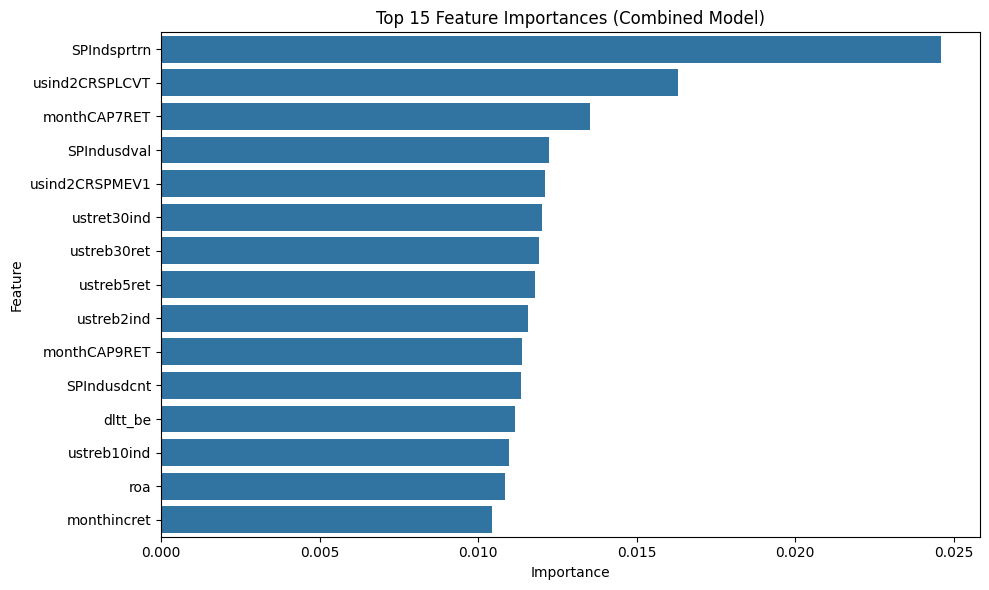

In [35]:
importances = model_combined.feature_importances_
feature_names = X_combined.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Top 15 Feature Importances (Combined Model)")
plt.tight_layout()
plt.show()

The original dataset consisted of 8 distinct credit rating categories (e.g., AAA, A+, BBB, BB, etc.). However, given the limited dataset size and class imbalance, training a robust multi-class model was impractical.

To address this, we grouped the ratings into two broader categories:

High: Ratings considered stable or strong (e.g., AAA, AA+, AA, A+)

Low: Ratings that reflect higher risk (e.g., BBB, BBB+, BB)

This binary classification approach improves model stability, simplifies interpretation, and aligns well with real-world credit screening tasks, where analysts often need a quick "safe vs risky" segmentation.



## Tried with Binary classification problem and basic NLP Feature Engineering

In [36]:
high_ratings = ['A+', 'AA', 'AA+', 'AAA']
low_ratings = ['BB', 'BBB', 'BBB+', 'A']

df['Rating_Group'] = df['Rating'].apply(lambda x: 'High' if x in high_ratings else 'Low')

from sklearn.preprocessing import LabelEncoder
group_encoder = LabelEncoder()
df['Rating_Group_encoded'] = group_encoder.fit_transform(df['Rating_Group'])

print(df[['Rating', 'Rating_Group', 'Rating_Group_encoded']].head())

  Rating Rating_Group  Rating_Group_encoded
0     A+         High                     0
1     BB          Low                     1
2     BB          Low                     1
3    BBB          Low                     1
4     AA         High                     0


In [37]:
df

,RATING_TYPE,Rating,FundaIndxint,FundaIndxsga,monthvwretd,monthvwretx,monthewretd,monthewretx,monthsprtrn,monthspindx,...,sale_equity,rd_sale,adv_sale,staff_sale,accrual,string_values,string_encoded,Rating_encoded,Rating_Group,Rating_Group_encoded
0,Fitch,A+,0.150659,-0.420047,-0.846934,0.560226,0.579303,-0.578314,-0.225006,-0.415867,...,-0.456676,1.878286,-1.338060,0.862565,0.822648,"Challenges remain in the supply chain, but str...",0,4,High,0
1,Moody's,BB,-0.015715,0.139204,-0.045250,-0.912128,0.497292,-0.910558,1.207592,-0.104050,...,-0.410984,1.426555,-1.121401,0.853764,0.978653,The company reported a steady increase in reve...,3,0,Low,1
2,Fitch,BB,-1.330074,0.001814,-2.564342,0.997115,0.762847,-0.870865,0.230487,0.515273,...,-0.825739,-2.171165,-0.533031,-0.615333,-0.302474,The company reported a steady increase in reve...,3,0,Low,1
3,Fitch,BBB,-0.025288,0.755935,1.142726,-0.235319,0.637967,-1.611961,0.432309,1.194182,...,0.811008,1.155982,-1.482237,0.000229,0.957513,The company reported a steady increase in reve...,3,1,Low,1
4,Moody's,AA,1.343168,1.933543,-1.896747,0.467780,-0.442432,1.349705,0.541002,0.096545,...,-0.936244,0.578200,-1.154929,0.531278,0.506149,The company reported a steady increase in reve...,3,5,High,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Moody's,BBB+,-0.815271,0.536027,-2.062526,0.643803,0.014212,1.143066,0.054319,0.640190,...,0.041870,-0.193072,-0.536025,0.708392,-0.697977,"The outlook remains positive, with expected gr...",4,2,Low,1
96,Moody's,AA,0.699092,0.840171,2.341975,0.683962,2.276652,-0.418705,1.138171,0.402768,...,0.432444,2.080314,1.201069,-1.304036,0.784470,"The outlook remains positive, with expected gr...",4,5,High,0
97,Fitch,BB,0.599897,1.133342,-1.101855,-0.144524,-1.629303,1.454928,-0.331587,0.689863,...,-0.089556,-0.000243,-0.336147,-0.373664,0.170525,"Challenges remain in the supply chain, but str...",0,0,Low,1
98,Moody's,AA+,-0.481248,-0.539745,1.611793,0.668101,0.109853,0.371594,0.618141,-1.163221,...,-0.921281,0.188730,-1.913430,0.114276,-0.387544,The company reported a steady increase in reve...,3,6,High,0


In [38]:
df_final

,FundaIndxint,FundaIndxsga,monthvwretd,monthvwretx,monthewretd,monthewretx,monthsprtrn,monthspindx,monthCAP1RET,monthCAP2RET,...,significantly,solid,steady,strategic,strong,supply,tax,volatility,year,sentiment_score
0,0.150659,-0.420047,-0.846934,0.560226,0.579303,-0.578314,-0.225006,-0.415867,-1.215753,-0.476301,...,0.0,0.0,0.00000,0.333333,0.000000,0.333333,0.0,0.0,0.0,0.000000
1,-0.015715,0.139204,-0.045250,-0.912128,0.497292,-0.910558,1.207592,-0.104050,0.154247,1.388313,...,0.0,0.0,0.34833,0.000000,0.308166,0.000000,0.0,0.0,0.0,0.300000
2,-1.330074,0.001814,-2.564342,0.997115,0.762847,-0.870865,0.230487,0.515273,-0.158655,1.659948,...,0.0,0.0,0.34833,0.000000,0.308166,0.000000,0.0,0.0,0.0,0.300000
3,-0.025288,0.755935,1.142726,-0.235319,0.637967,-1.611961,0.432309,1.194182,-1.186642,1.275644,...,0.0,0.0,0.34833,0.000000,0.308166,0.000000,0.0,0.0,0.0,0.300000
4,1.343168,1.933543,-1.896747,0.467780,-0.442432,1.349705,0.541002,0.096545,-0.370209,0.230641,...,0.0,0.0,0.34833,0.000000,0.308166,0.000000,0.0,0.0,0.0,0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.815271,0.536027,-2.062526,0.643803,0.014212,1.143066,0.054319,0.640190,-1.363040,-1.334804,...,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.031818
96,0.699092,0.840171,2.341975,0.683962,2.276652,-0.418705,1.138171,0.402768,-0.672489,1.109260,...,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.031818
97,0.599897,1.133342,-1.101855,-0.144524,-1.629303,1.454928,-0.331587,0.689863,-2.284820,-1.462036,...,0.0,0.0,0.00000,0.333333,0.000000,0.333333,0.0,0.0,0.0,0.000000
98,-0.481248,-0.539745,1.611793,0.668101,0.109853,0.371594,0.618141,-1.163221,-0.489539,1.171581,...,0.0,0.0,0.34833,0.000000,0.308166,0.000000,0.0,0.0,0.0,0.300000


In [39]:
target = 'Rating_Group_encoded'

text_features = list(tfidf_df.columns) + ['sentiment_score']+['string_encoded']
structured_features = [col for col in df_final.columns if col not in text_features + ['Rating_encoded']]

df_final['Rating_Group_encoded'] = df['Rating_Group_encoded']
y = df_final[target]


### Modeling and hyper parameter tuning

In [40]:
from sklearn.model_selection import train_test_split

X_structured = df_final[structured_features]
X_text = df_final[text_features]
X_combined = df_final[structured_features + text_features]

X_train_s, X_test_s, y_train, y_test = train_test_split(X_structured, y, test_size=0.4, random_state=42, stratify=y)
X_train_t = X_text.loc[X_train_s.index]
X_test_t = X_text.loc[X_test_s.index]
X_train_c = X_combined.loc[X_train_s.index]
X_test_c = X_combined.loc[X_test_s.index]


In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

def train_and_evaluate_decision_tree(X_train, X_test, y_train, y_test, label="Binary Model"):
    model = DecisionTreeClassifier(max_depth=5, random_state=42)  # You can tune max_depth
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n Results for {label}:")
    print(classification_report(y_test, y_pred, target_names=group_encoder.classes_))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    return model

dt_structured = train_and_evaluate_decision_tree(X_train_s, X_test_s, y_train, y_test, "Decision Tree - Structured Only")
dt_text = train_and_evaluate_decision_tree(X_train_t, X_test_t, y_train, y_test, "Decision Tree - Text Only")
dt_combined = train_and_evaluate_decision_tree(X_train_c, X_test_c, y_train, y_test, "Decision Tree - Combined Model")



 Results for Decision Tree - Structured Only:
              precision    recall  f1-score   support

        High       0.69      0.45      0.55        20
         Low       0.59      0.80      0.68        20

    accuracy                           0.62        40
   macro avg       0.64      0.62      0.61        40
weighted avg       0.64      0.62      0.61        40

Confusion Matrix:
[[ 9 11]
 [ 4 16]]

 Results for Decision Tree - Text Only:
              precision    recall  f1-score   support

        High       0.75      0.15      0.25        20
         Low       0.53      0.95      0.68        20

    accuracy                           0.55        40
   macro avg       0.64      0.55      0.46        40
weighted avg       0.64      0.55      0.46        40

Confusion Matrix:
[[ 3 17]
 [ 1 19]]

 Results for Decision Tree - Combined Model:
              precision    recall  f1-score   support

        High       0.64      0.35      0.45        20
         Low       0.55      

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix



In [43]:
def tune_random_forest(X_train, y_train):
    param_grid = {
        'n_estimators': [50,  200],
        'max_depth': [3, 5, None],
        'min_samples_split': [2],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    }

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, scoring='f1', verbose=1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_


In [44]:
def train_and_evaluate_best_model(X_train, X_test, y_train, y_test, label):
    best_model, best_params = tune_random_forest(X_train, y_train)
    y_pred = best_model.predict(X_test)

    print(f"\n Results for {label}:")
    print(classification_report(y_test, y_pred, target_names=group_encoder.classes_))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return best_model


In [45]:
best_model_structured = train_and_evaluate_best_model(X_train_s, X_test_s, y_train, y_test, "Tuned RF - Structured Only")
best_model_text = train_and_evaluate_best_model(X_train_t, X_test_t, y_train, y_test, "Tuned RF - Text Only")
best_model_combined = train_and_evaluate_best_model(X_train_c, X_test_c, y_train, y_test, "Tuned RF - Combined Model")

Fitting 3 folds for each of 24 candidates, totalling 72 fits

 Results for Tuned RF - Structured Only:
              precision    recall  f1-score   support

        High       0.73      0.40      0.52        20
         Low       0.59      0.85      0.69        20

    accuracy                           0.62        40
   macro avg       0.66      0.62      0.61        40
weighted avg       0.66      0.62      0.61        40

Confusion Matrix:
[[ 8 12]
 [ 3 17]]
Fitting 3 folds for each of 24 candidates, totalling 72 fits

 Results for Tuned RF - Text Only:
              precision    recall  f1-score   support

        High       0.75      0.15      0.25        20
         Low       0.53      0.95      0.68        20

    accuracy                           0.55        40
   macro avg       0.64      0.55      0.46        40
weighted avg       0.64      0.55      0.46        40

Confusion Matrix:
[[ 3 17]
 [ 1 19]]
Fitting 3 folds for each of 24 candidates, totalling 72 fits

 Results f

### Feature Importance

In [46]:
from sklearn.metrics import roc_curve, auc
importances_df = {}
def plot_roc_curve(model, X_test, y_test, label):
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")


def plot_feature_importance(model, feature_names, label):
    importances = model.feature_importances_
    indices = importances.argsort()[::-1][:10]  # Top 10
    plt.figure(figsize=(8, 4))
    plt.title(f"Top 10 Feature Importances - {label}")
    plt.barh(range(len(indices)), importances[indices][::-1])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices][::-1])
    plt.tight_layout()
    plt.show()


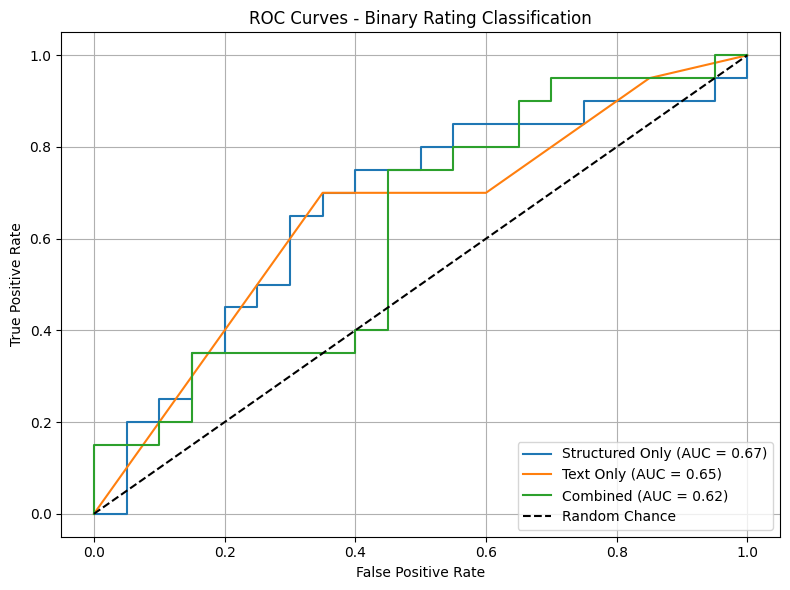

In [47]:
plt.figure(figsize=(8, 6))
plot_roc_curve(best_model_structured, X_test_s, y_test, "Structured Only")
plot_roc_curve(best_model_text, X_test_t, y_test, "Text Only")
plot_roc_curve(best_model_combined, X_test_c, y_test, "Combined")
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.title("ROC Curves - Binary Rating Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


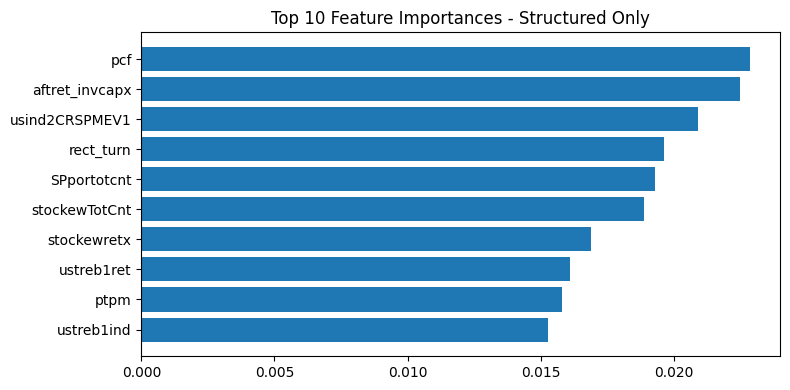

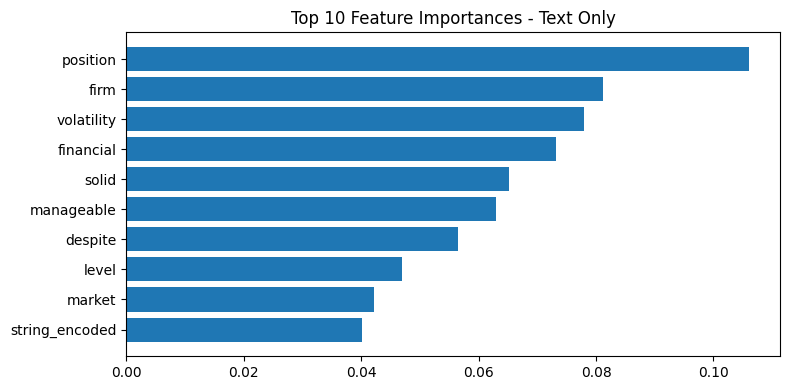

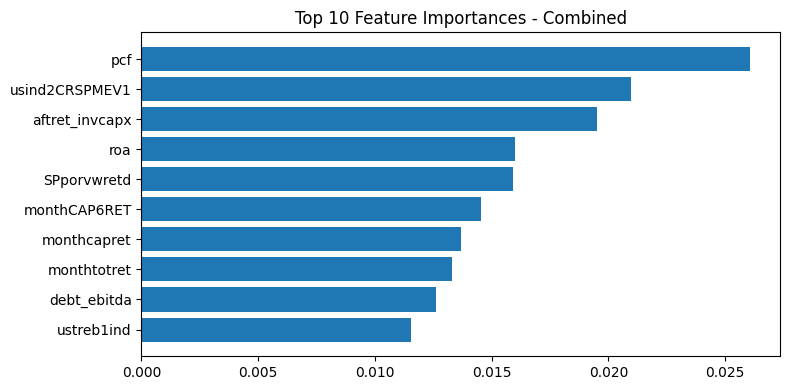

In [48]:
plot_feature_importance(best_model_structured, X_train_s.columns, "Structured Only")
plot_feature_importance(best_model_text, X_train_t.columns, "Text Only")
plot_feature_importance(best_model_combined, X_train_c.columns, "Combined")


## Tried with Binary  classification problem and advanced NLP Feature Engineering

In [49]:

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
file_path = "/content/Artificial_Data.xlsx"
df = pd.read_excel(file_path)

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### TF-IDF representaion

In [50]:
df['clean_text'] = df['string_values'].apply(clean_text)
tfidf = TfidfVectorizer(max_features=50)
tfidf_matrix = tfidf.fit_transform(df['clean_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
df = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

### Word2Vec Word embeddings

In [51]:
tokenized = [text.split() for text in df['clean_text']]
w2v_model = Word2Vec(sentences=tokenized, vector_size=50, window=5, min_count=1, workers=4)

def get_w2v_vector(words):
    vec = np.zeros(50)
    count = 0
    for word in words:
        if word in w2v_model.wv:
            vec += w2v_model.wv[word]
            count += 1
    return vec / count if count > 0 else vec

w2v_features = np.array([get_w2v_vector(words) for words in tokenized])
w2v_df = pd.DataFrame(w2v_features, columns=[f'w2v_{i}' for i in range(50)])
df = pd.concat([df, w2v_df], axis=1)


### Sentiment Analysis

In [52]:
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
bert_embeddings = bert_model.encode(df['clean_text'].tolist(), show_progress_bar=True)
bert_df = pd.DataFrame(bert_embeddings, columns=[f'bert_{i}' for i in range(bert_embeddings.shape[1])])
df = pd.concat([df.reset_index(drop=True), bert_df.reset_index(drop=True)], axis=1)

df['sentiment_score'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

### topic modeling

In [53]:
count_vectorizer = CountVectorizer(max_features=20)
doc_term_matrix = count_vectorizer.fit_transform(df['clean_text'])
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda_topics = lda.fit_transform(doc_term_matrix)

lda_df = pd.DataFrame(lda_topics, columns=[f'topic_{i}' for i in range(lda.n_components)])
df = pd.concat([df.reset_index(drop=True), lda_df.reset_index(drop=True)], axis=1)

In [54]:
df

,RATING_TYPE,Rating,FundaIndxint,FundaIndxsga,monthvwretd,monthvwretx,monthewretd,monthewretx,monthsprtrn,monthspindx,...,bert_378,bert_379,bert_380,bert_381,bert_382,bert_383,sentiment_score,topic_0,topic_1,topic_2
0,Fitch,A+,0.150659,-0.420047,-0.846934,0.560226,0.579303,-0.578314,-0.225006,-0.415867,...,-0.053729,0.042802,-0.022389,-0.099385,0.060410,-0.017017,0.000000,0.042221,0.916103,0.041677
1,Moody's,BB,-0.015715,0.139204,-0.045250,-0.912128,0.497292,-0.910558,1.207592,-0.104050,...,-0.110882,0.013918,0.043043,-0.074914,0.070740,0.013117,0.300000,0.033676,0.033649,0.932675
2,Fitch,BB,-1.330074,0.001814,-2.564342,0.997115,0.762847,-0.870865,0.230487,0.515273,...,-0.110882,0.013918,0.043043,-0.074914,0.070740,0.013117,0.300000,0.033676,0.033649,0.932675
3,Fitch,BBB,-0.025288,0.755935,1.142726,-0.235319,0.637967,-1.611961,0.432309,1.194182,...,-0.110882,0.013918,0.043043,-0.074914,0.070740,0.013117,0.300000,0.033676,0.033649,0.932675
4,Moody's,AA,1.343168,1.933543,-1.896747,0.467780,-0.442432,1.349705,0.541002,0.096545,...,-0.110882,0.013918,0.043043,-0.074914,0.070740,0.013117,0.300000,0.033676,0.033649,0.932675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Moody's,BBB+,-0.815271,0.536027,-2.062526,0.643803,0.014212,1.143066,0.054319,0.640190,...,-0.016187,0.022282,-0.007640,-0.115511,-0.027494,0.031533,0.031818,0.056438,0.885103,0.058459
96,Moody's,AA,0.699092,0.840171,2.341975,0.683962,2.276652,-0.418705,1.138171,0.402768,...,-0.016187,0.022282,-0.007640,-0.115511,-0.027494,0.031533,0.031818,0.056438,0.885103,0.058459
97,Fitch,BB,0.599897,1.133342,-1.101855,-0.144524,-1.629303,1.454928,-0.331587,0.689863,...,-0.053729,0.042802,-0.022389,-0.099385,0.060410,-0.017017,0.000000,0.042221,0.916103,0.041677
98,Moody's,AA+,-0.481248,-0.539745,1.611793,0.668101,0.109853,0.371594,0.618141,-1.163221,...,-0.110882,0.013918,0.043043,-0.074914,0.070740,0.013117,0.300000,0.033676,0.033649,0.932675


### Modeling

In [55]:
high_ratings = ['A+', 'AA', 'AA+', 'AAA']
low_ratings = ['BB', 'BBB', 'BBB+', 'A']

df['Rating_Group'] = df['Rating'].apply(lambda x: 'High' if x in high_ratings else 'Low')

from sklearn.preprocessing import LabelEncoder
group_encoder = LabelEncoder()
df['Rating_Group_encoded'] = group_encoder.fit_transform(df['Rating_Group'])

print(df[['Rating', 'Rating_Group', 'Rating_Group_encoded']].head())

  Rating Rating_Group  Rating_Group_encoded
0     A+         High                     0
1     BB          Low                     1
2     BB          Low                     1
3    BBB          Low                     1
4     AA         High                     0


In [56]:
df['string_encoded'] = string_encoder.fit_transform(df['string_values'])


In [57]:
# Combine selected features
text_features = list(tfidf_df.columns) + [f'w2v_{i}' for i in range(50)] \
                + [f'bert_{i}' for i in range(384)] + ['sentiment_score']+['string_encoded'] \
                + [f'topic_{i}' for i in range(3)]

df_final = pd.concat([df.reset_index(drop=True), tfidf_df, w2v_df, bert_df, lda_df], axis=1)


In [58]:
rating_type_encoded = pd.get_dummies(df_final['RATING_TYPE'], prefix='RATING_TYPE')
df_cleaned = df_final.drop(columns=['Rating', 'RATING_TYPE','Rating_Group_encoded'])
df_final = pd.concat([df_cleaned, rating_type_encoded], axis=1)

In [59]:

#df_final = df_final.drop(columns=['clean_text'])


In [60]:
from sklearn.model_selection import train_test_split

target = 'Rating_Group'
structured_features = [col for col in df_final.columns if col not in text_features + [target]]

# Prepare feature sets
X_structured = df_final[structured_features]
X_text = df_final[text_features]
X_combined = df_final[structured_features + text_features]
y = df_final[target]

# Train-test split
X_train_s, X_test_s, y_train, y_test = train_test_split(X_structured, y, test_size=0.2, random_state=42)
X_train_t, X_test_t, _, _ = train_test_split(X_text, y, test_size=0.2, random_state=42)
X_train_c, X_test_c, _, _ = train_test_split(X_combined, y, test_size=0.2, random_state=42)


In [61]:
structured_features

['FundaIndxint',
 'FundaIndxsga',
 'monthvwretd',
 'monthvwretx',
 'monthewretd',
 'monthewretx',
 'monthsprtrn',
 'monthspindx',
 'monthCAP1RET',
 'monthCAP2RET',
 'monthCAP3RET',
 'monthCAP4RET',
 'monthCAP5RET',
 'monthCAP6RET',
 'monthCAP7RET',
 'monthCAP8RET',
 'monthCAP9RET',
 'monthCAP10RET',
 'monthtotval',
 'monthtotcnt',
 'monthusdval',
 'monthusdcnt',
 'monthprtcnt',
 'monthtotret',
 'monthtotind',
 'monthcapret',
 'monthcapind',
 'monthincret',
 'monthincind',
 'SPIndvwretd',
 'SPIndvwretx',
 'SPIndewretd',
 'SPIndewretx',
 'SPIndtotval',
 'SPIndtotcnt',
 'SPIndusdval',
 'SPIndusdcnt',
 'SPIndspindx',
 'SPIndsprtrn',
 'SPporvwretd',
 'SPporvwretx',
 'SPporewretd',
 'SPporewretx',
 'SPportotval',
 'SPportotcnt',
 'SPporusdval',
 'SPporusdcnt',
 'SPporspindx',
 'SPporsprtrn',
 'usind2CRSPMEV1',
 'usind2CRSPMEG1',
 'usind2CRSPLCV1',
 'usind2CRSPLCG1',
 'usind2CRSPMIV1',
 'usind2CRSPMIG1',
 'usind2CRSPSCV1',
 'usind2CRSPSCG1',
 'usind2CRSPMEVT',
 'usind2CRSPMEGT',
 'usind2CRSPL

In [62]:
text_features

['chain',
 'challenge',
 'company',
 'cost',
 'debt',
 'demand',
 'despite',
 'domestic',
 'driven',
 'earnings',
 'efficiency',
 'expected',
 'financial',
 'firm',
 'growth',
 'improved',
 'improving',
 'increase',
 'interest',
 'international',
 'investment',
 'last',
 'level',
 'liquidity',
 'logistics',
 'manageable',
 'market',
 'measure',
 'outlook',
 'position',
 'positive',
 'reduction',
 'reflecting',
 'remain',
 'remains',
 'reported',
 'revenue',
 'significantly',
 'solid',
 'steady',
 'strategic',
 'strong',
 'supply',
 'tax',
 'volatility',
 'year',
 'w2v_0',
 'w2v_1',
 'w2v_2',
 'w2v_3',
 'w2v_4',
 'w2v_5',
 'w2v_6',
 'w2v_7',
 'w2v_8',
 'w2v_9',
 'w2v_10',
 'w2v_11',
 'w2v_12',
 'w2v_13',
 'w2v_14',
 'w2v_15',
 'w2v_16',
 'w2v_17',
 'w2v_18',
 'w2v_19',
 'w2v_20',
 'w2v_21',
 'w2v_22',
 'w2v_23',
 'w2v_24',
 'w2v_25',
 'w2v_26',
 'w2v_27',
 'w2v_28',
 'w2v_29',
 'w2v_30',
 'w2v_31',
 'w2v_32',
 'w2v_33',
 'w2v_34',
 'w2v_35',
 'w2v_36',
 'w2v_37',
 'w2v_38',
 'w2v_39',
 

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

def train_and_evaluate(X_train, X_test, y_train, y_test, label):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f" Results for {label}:")
    print(classification_report(y_test, y_pred))
    print(" Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return model


In [64]:
# Structured features
rf_structured = train_and_evaluate(
    X_train_s.select_dtypes(include='number'),
    X_test_s.select_dtypes(include='number'),
    y_train, y_test,
    label="Structured Features"
)

# Text features
rf_text = train_and_evaluate(
    X_train_t.select_dtypes(include='number'),
    X_test_t.select_dtypes(include='number'),
    y_train, y_test,
    label="Text Features"
)

# Combined features
rf_combined = train_and_evaluate(
    X_train_c.select_dtypes(include='number'),
    X_test_c.select_dtypes(include='number'),
    y_train, y_test,
    label="Combined Features"
)


 Results for Structured Features:
              precision    recall  f1-score   support

        High       0.33      0.20      0.25        10
         Low       0.43      0.60      0.50        10

    accuracy                           0.40        20
   macro avg       0.38      0.40      0.38        20
weighted avg       0.38      0.40      0.38        20

 Confusion Matrix:
[[2 8]
 [4 6]]
 Results for Text Features:
              precision    recall  f1-score   support

        High       0.67      0.20      0.31        10
         Low       0.53      0.90      0.67        10

    accuracy                           0.55        20
   macro avg       0.60      0.55      0.49        20
weighted avg       0.60      0.55      0.49        20

 Confusion Matrix:
[[2 8]
 [1 9]]
 Results for Combined Features:
              precision    recall  f1-score   support

        High       0.60      0.30      0.40        10
         Low       0.53      0.80      0.64        10

    accuracy        

### Feature Importance & ROC Curves

In [65]:
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test).ravel()


In [66]:
def plot_roc(model, X_test, y_test_bin, label):
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_bin, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")


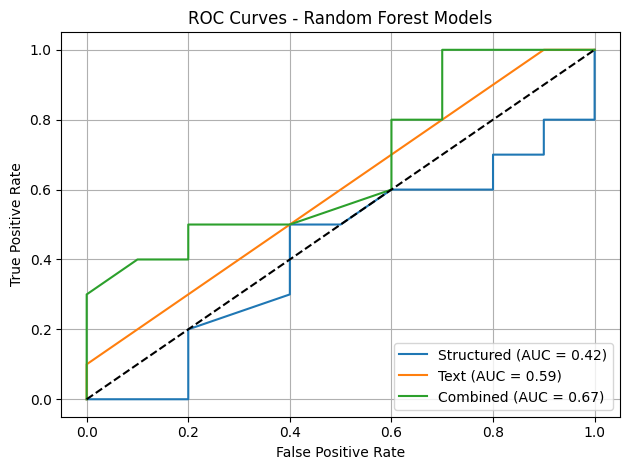

In [67]:

plot_roc(rf_structured, X_test_s.select_dtypes(include='number'), y_test_bin, "Structured")
plot_roc(rf_text, X_test_t.select_dtypes(include='number'), y_test_bin, "Text")
plot_roc(rf_combined, X_test_c.select_dtypes(include='number'), y_test_bin, "Combined")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves - Random Forest Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


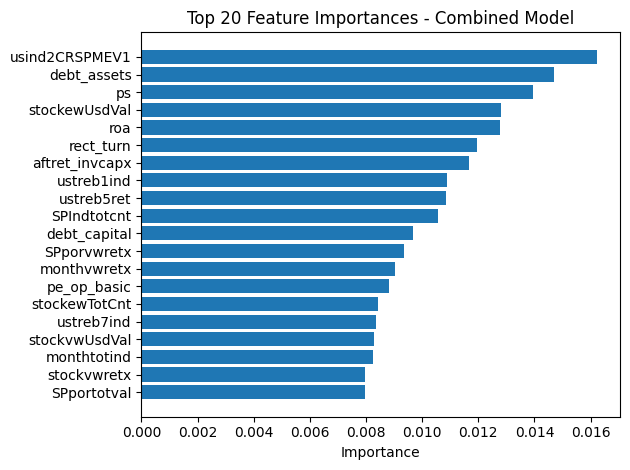

In [68]:

importances = rf_combined.feature_importances_
features = X_train_c.select_dtypes(include='number').columns
indices = np.argsort(importances)[-20:]

plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features[indices])
plt.title("Top 20 Feature Importances - Combined Model")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


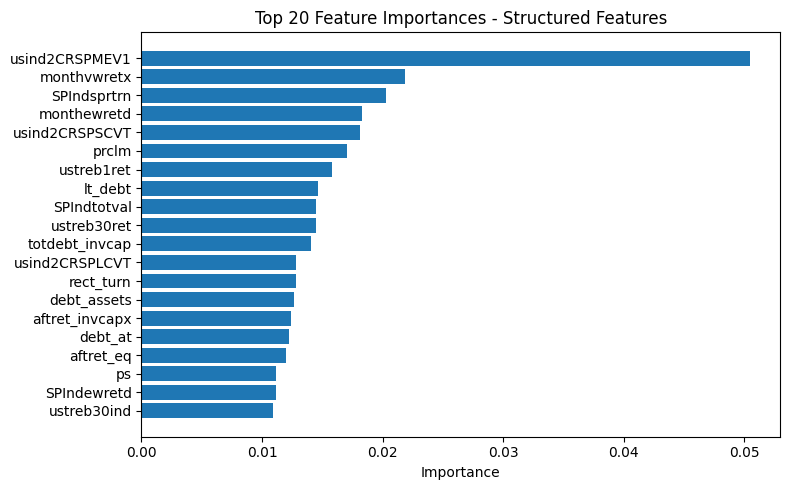

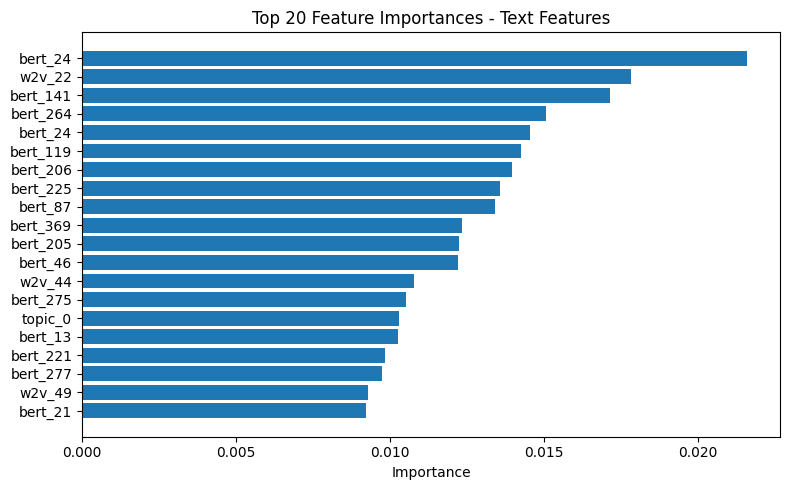

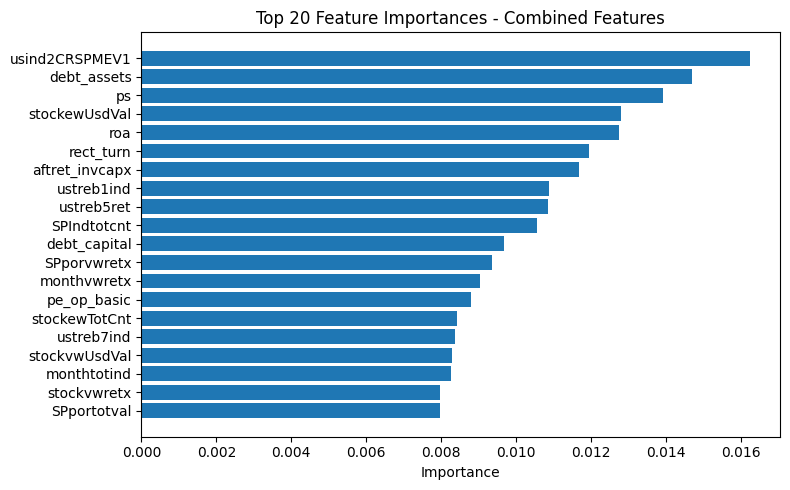

In [69]:
def plot_feature_importance(model, X_train, label):
    importances = model.feature_importances_
    features = X_train.select_dtypes(include='number').columns
    indices = np.argsort(importances)[-20:]

    plt.figure(figsize=(8, 5))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.title(f"Top 20 Feature Importances - {label}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

# Structured model
plot_feature_importance(rf_structured, X_train_s, "Structured Features")

# Text model
plot_feature_importance(rf_text, X_train_t, "Text Features")

# Combined model
plot_feature_importance(rf_combined, X_train_c, "Combined Features")

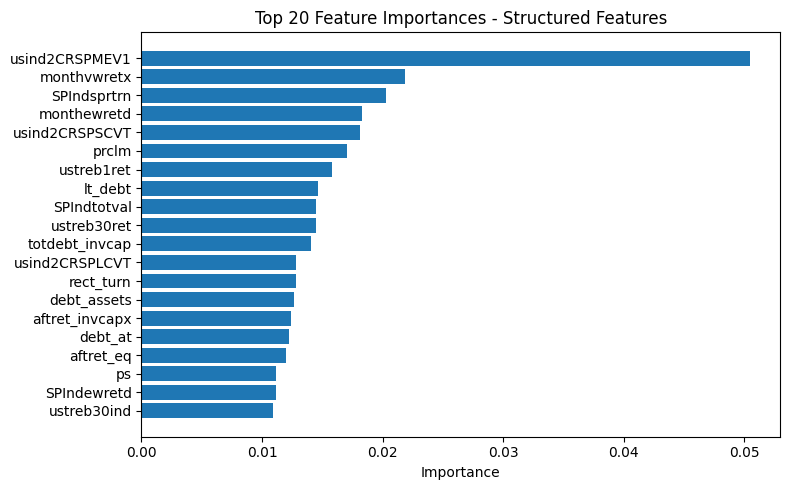

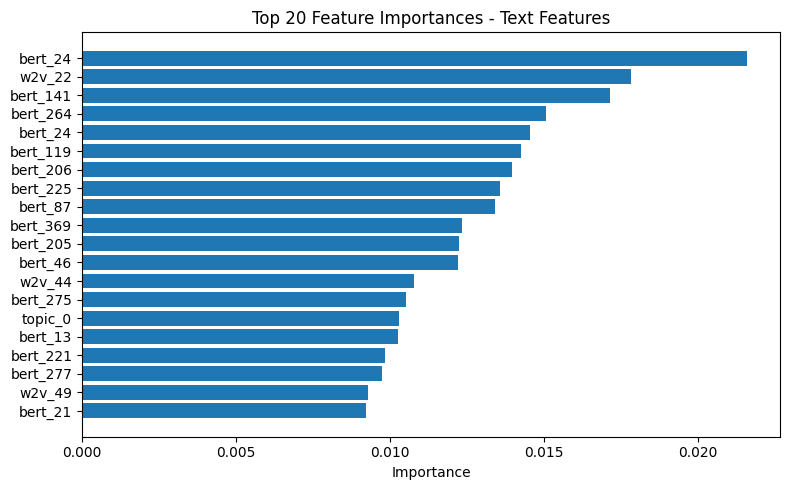

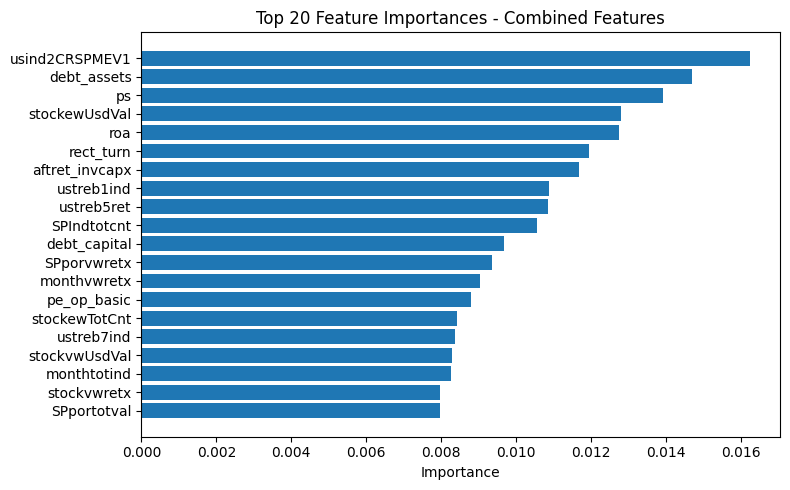

In [70]:
# Structured model
plot_feature_importance(rf_structured, X_train_s, "Structured Features")

# Text model
plot_feature_importance(rf_text, X_train_t, "Text Features")

# Combined model
plot_feature_importance(rf_combined, X_train_c, "Combined Features")

In [74]:
def get_top_feature_importance_df(model, X_train, label, top_n=10):
    importances = model.feature_importances_
    features = X_train.select_dtypes(include='number').columns
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(top_n)

    importance_df['Model'] = label
    return importance_df


## Analysis

In [75]:
df_structured_importance = get_top_feature_importance_df(rf_structured, X_train_s, "Structured")
df_text_importance = get_top_feature_importance_df(rf_text, X_train_t, "Text")
df_combined_importance = get_top_feature_importance_df(rf_combined, X_train_c, "Combined")


In [76]:
df_structured_importance

,Feature,Importance,Model
49,usind2CRSPMEV1,0.050424,Structured
3,monthvwretx,0.021810,Structured
38,SPIndsprtrn,0.020251,Structured
4,monthewretd,0.018250,Structured
63,usind2CRSPSCVT,0.018086,Structured
102,prclm,0.017055,Structured
90,ustreb1ret,0.015762,Structured
135,lt_debt,0.014628,Structured
33,SPIndtotval,0.014512,Structured
78,ustreb30ret,0.014491,Structured


In [78]:
df_text_importance

,Feature,Importance,Model
241,bert_24,0.021585,Text
136,w2v_22,0.017820,Text
475,bert_141,0.017137,Text
721,bert_264,0.015061,Text
240,bert_24,0.014560,Text
431,bert_119,0.014247,Text
605,bert_206,0.013959,Text
642,bert_225,0.013582,Text
366,bert_87,0.013426,Text
931,bert_369,0.012344,Text


In [79]:
df_combined_importance

,Feature,Importance,Model
49,usind2CRSPMEV1,0.016234,Combined
139,debt_assets,0.014683,Combined
113,ps,0.013929,Combined
74,stockewUsdVal,0.012792,Combined
121,roa,0.012755,Combined
143,rect_turn,0.011947,Combined
125,aftret_invcapx,0.011678,Combined
91,ustreb1ind,0.010879,Combined
86,ustreb5ret,0.010864,Combined
34,SPIndtotcnt,0.010560,Combined


In [80]:
df_all_importance = pd.concat([
    df_structured_importance,
    df_text_importance,
    df_combined_importance
], ignore_index=True)

df_all_importance.head(15)

,Feature,Importance,Model
0,usind2CRSPMEV1,0.050424,Structured
1,monthvwretx,0.021810,Structured
2,SPIndsprtrn,0.020251,Structured
3,monthewretd,0.018250,Structured
4,usind2CRSPSCVT,0.018086,Structured
5,prclm,0.017055,Structured
6,ustreb1ret,0.015762,Structured
7,lt_debt,0.014628,Structured
8,SPIndtotval,0.014512,Structured
9,ustreb30ret,0.014491,Structured


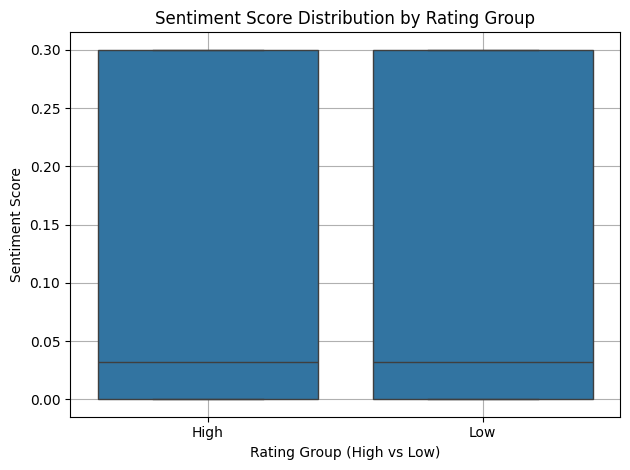

In [83]:
sns.boxplot(data=df_final, x='Rating_Group', y='sentiment_score')
plt.title("Sentiment Score Distribution by Rating Group")
plt.xlabel("Rating Group (High vs Low)")
plt.ylabel("Sentiment Score")
plt.grid(True)
plt.tight_layout()
plt.show()

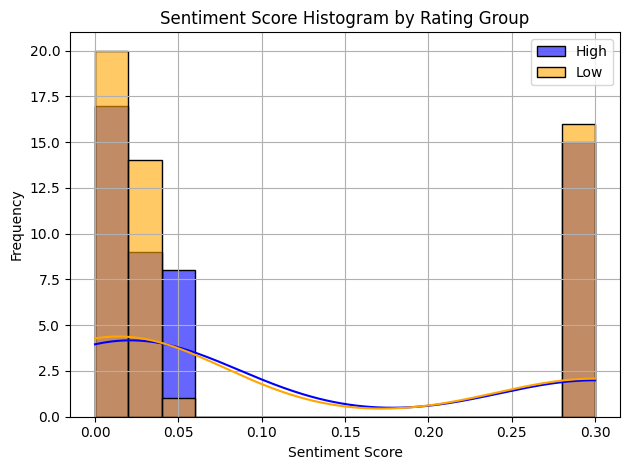

In [87]:
sns.histplot(data=df_final[df_final['Rating_Group'] == 'High'], x='sentiment_score',
             color='blue', label='High', kde=True, bins=15, alpha=0.6)

sns.histplot(data=df_final[df_final['Rating_Group'] == 'Low'], x='sentiment_score',
             color='orange', label='Low', kde=True, bins=15, alpha=0.6)

plt.title("Sentiment Score Histogram by Rating Group")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Both High and Low rating groups cluster sentiment scores around 0.0 to 0.05, but:

The Low group shows a heavier density near zero (neutral/negative), indicating more cautious or negative sentiment.

The High group appears slightly more skewed toward higher sentiment (positive zone around 0.3).



This supports the idea that sentiment scores can act as a predictive signal. Companies with consistently lower sentiment in their disclosures may be more likely to receive a low rating or even face a downgrade.


In [86]:
df_final['sentiment_score']

,sentiment_score
0,0.000000
1,0.300000
2,0.300000
3,0.300000
4,0.300000
...,...
95,0.031818
96,0.031818
97,0.000000
98,0.300000


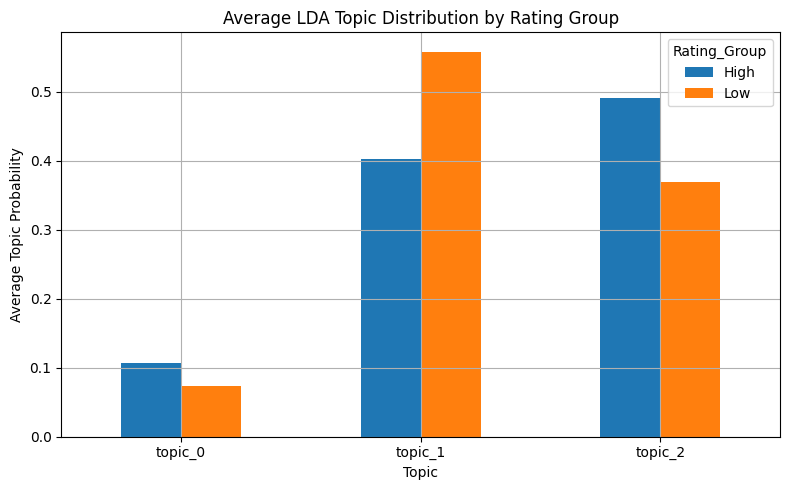

In [82]:
topic_cols = [col for col in df.columns if col.startswith('topic_')]
df_topic_avg = df.groupby("Rating_Group")[topic_cols].mean()

df_topic_avg.T.plot(kind='bar', figsize=(8, 5))
plt.title("Average LDA Topic Distribution by Rating Group")
plt.ylabel("Average Topic Probability")
plt.xlabel("Topic")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

Topic 1 appears much more strongly in Low-rated companies, suggesting this theme may represent financial concerns, market instability, or negative business outlooks.

Topic 2 dominates more in High-rated firms, potentially aligned with themes of growth, investment, or operational strength.

Regulatory teams or credit analysts can:

Use sentiment scores as early warnings of potential downgrades.

Monitor emerging negative topics (Topic 1) across portfolios to take proactive steps.

Combine structured and unstructured data for automated credit scoring pipelines.

Investors or lenders may:

Prioritize review of companies with negative sentiment + Topic 1 dominance

Gain confidence from companies with positive tone and Topic 2 alignment

### Conclusion

My multimodal analysis reveals that unstructured text in company summaries (like financial news or commentary) contains valuable predictive signals.
Specifically:

Negative sentiment (e.g., challenges, risk terms) is correlated with lower credit ratings.

BERT embeddings and Word2Vec features such as bert_24, bert_141, and w2v_22 consistently appeared among top predictors in the text model.

Topic modeling shows that specific themes (e.g., liquidity concerns, supply chain issues) are more prevalent in lower-rated companies.

 Implication:
Regulatory teams, credit risk analysts, or investment firms can use these signals to:

Automate credit risk alerts

Pre-empt rating downgrades

Monitor portfolios based on NLP-driven sentiment shifts

In [89]:
import subprocess

# Export installed packages to requirements.txt
with open("requirements.txt", "w") as f:
    subprocess.run(["pip", "freeze"], stdout=f)